## Reference :

- https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a
- https://www.youtube.com/watch?v=MnRskV3NY1k&t=1571s&ab_channel=T%C3%BCbingenMachineLearning
- https://www.dailydoseofds.com/formulating-and-implementing-the-t-sne-algorithm-from-scratch/

# 2. (5 pts) Dimension Reduction Using t-SNE

## 2.1 (2 pts) Please build the t-SNE algorithm from scratch based on the equations below:

Please cite if you are referring to any source for the algorithms.
There are many hyperparameters to optimize, such as initialization (random seed), learning rate 𝜆 , momentum
𝛼(𝑡), iteration number, and perplexity.



$$

P_{j|i} = \frac{\exp\left(- \frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(- \frac{\|x_i - x_k\|^2}{2\sigma_i^2}\right)}

\\ 

\[
q_{j|i} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
\]

\\ 

\[
C = KL(P||Q) = \sum_i \sum_j P_{j|i} \log \frac{P_{j|i}}{q_{j|i}}
\]

\\

\[
\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + \|y_i - y_j\|^2)^{-1}
\]

\\

\[
y^{(t)} = y^{(t-1)} + \lambda \frac{\partial C}{\partial y} + \alpha(t)(y^{(t-1)} - y^{(t-2)})
\]

$$

In [1]:
import pandas as pd

df = pd.read_csv('fashion_mnist1.csv')
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
print(f"{X.shape = }, {y.shape = }")

X.shape = (10000, 784), y.shape = (10000,)


In [2]:
n_sample = 20


In [13]:
import sys
import numpy as np
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(2024)
warnings.filterwarnings("ignore")


class TSNE:
    
    def __init__(self, perplexity=10, iterations=1000, n_components=2, learning_rate=100, momentum=0.5, initialization_method ='random', random_state=42):
        """
        t-SNE algorithm parameters
            :param perplexity: Perplexity
            :param iterations: number of Iterations the gradient descent algorithm will run
            :param n_components: Number of components
            :param learning_rate: Learning Rate
            :param momentum: momentum
            :param initialization_method: Initialization method for the t-SNE
            :param random_state: Random State
        """
        self.perplexity = perplexity
        self.iterations = iterations
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.initialization_method = initialization_method
        self.random_state = random_state
        
    def _params(self):
        parameters = {
            'perplexity': self.perplexity,
            'iters': self.iterations,
            'lrn_rate': self.learning_rate,
            'momentum': self.momentum,
            'init_method': self.initialization_method,
        }
        return ",".join(f"{k}={v}" for k, v in parameters.items())
            
    def _find_sigma(self, norm, i, perplexity):
        """
        Helper function to obtain σ's based on user-specified perplexity.
            :param norm: pairwise squared differences between data points
            :param i: Iteration number
            :param perplexity: desired Perplexity
        
        return: sigma that satisfies the perplexity condition.
        """
        result = np.inf  # Set first result to be infinity
        std_norm = np.std(norm)  # Use standard deviation of norms to define search space
        sigma = 0
        for sigma_i in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
            # Equation 1 Numerator
            p = np.exp(-(norm**2) / (2 * sigma_i**2))
            p[i] = 0
    
            p_new = np.maximum(p / np.sum(p), sys.float_info.min)
    
            # Shannon Entropy
            H = -np.sum(p_new * np.log2(p_new))
    
            # Get log(perplexity equation) as close to equality
            if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
                result = np.log(perplexity) - H * np.log(2)
                sigma = sigma_i
    
        return sigma
    
    def get_original_pairwise_affinities(self, X, perplexity):
        """
        param:
            X - input data
            perplexity: perplexity
    
        return: original high dimension probability
        """
    
        n = X.shape[0]
        print("Starting the high dimension computation...")
        p_ij = np.zeros(shape=(n, n))
        with tqdm(total=n) as _:
            for i in range(0, n):
                diff = X[i] - X
                
                norm = np.linalg.norm(diff, axis=1)
                sigma_i = self._find_sigma(norm, i, perplexity)  
                p_ij[i, :] = np.exp(-(norm**2) / (2 * sigma_i**2))
                np.fill_diagonal(p_ij, 0)
                p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])
    
        p_ij = np.maximum(p_ij, sys.float_info.min)
        print("Completed the high dimension computation...")
        return p_ij
    
    def get_symmetric_p_ij(self, p_ij):
        """
        Function to obtain symmetric affinities matrix utilized in t-SNE.
    
        Parameters:
        p_ij (np.ndarray): The input affinity matrix.
    
        Returns:
        np.ndarray: The symmetric affinities matrix.
    
        """
        # print("Computing Symmetric p_ij matrix....")
        # 
        # n = len(p_ij)
        # p_ij_symmetric = np.zeros(shape=(n, n))
        # for i in range(0, n):
        #     for j in range(0, n):
        #         p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)
        # 
        # # Set 0 values to minimum numpy value (ε approx. = 0)
        # ε = np.nextafter(0, 1)
        # p_ij_symmetric = np.maximum(p_ij_symmetric, ε)
        # 
        # print("Completed Symmetric p_ij Matrix. \n")
        # 
        # return p_ij_symmetric
        n = p_ij.shape[0]
        p_ij = (p_ij + p_ij.T) / (2 * n)
        p_ij = np.maximum(p_ij, sys.float_info.min)
        return p_ij
    
    def get_low_dimensional_affinities(self, Y):
        """
        Obtain low-dimensional affinities.
            :param Y: input data
        
        return: low-dimensional affinities matrix.
        """
    
        n = len(Y)
        q_ij = np.zeros(shape=(n, n))
    
        for i in range(0, n):
            # Equation 4 Numerator
            diff = Y[i] - Y
            norm = np.linalg.norm(diff, axis=1)
            q_ij[i, :] = (1 + norm**2) ** (-1)
    
        # Set p = 0 when j = i
        np.fill_diagonal(q_ij, 0)
    
        # Equation 4
        q_ij = q_ij / q_ij.sum()
    
        # Set 0 values to minimum numpy value (ε approx. = 0)
        q_ij = np.maximum(q_ij, sys.float_info.min)
    
        return q_ij
    
    def _gradient(self, p_ij, q_ij, Y):
        """
        Obtain gradient of cost function at current point Y.
    
        Parameters:
        p_ij (np.ndarray): The joint probability distribution matrix.
        q_ij (np.ndarray): The Student's t-distribution matrix.
        Y (np.ndarray): The current point in the low-dimensional space.
    
        Returns:
        np.ndarray: The gradient of the cost function at the current point Y.
        """
    
        n = len(p_ij)
    
        # Compute gradient
        gradient = np.zeros(shape=(n, Y.shape[1]))
        for i in range(0, n):
            # Equation 5
            diff = Y[i] - Y
            A = np.array([(p_ij[i, :] - q_ij[i, :])])
            B = np.array([(1 + np.linalg.norm(diff, axis=1)) ** (-1)])
            C = diff
            gradient[i] = 4 * np.sum((A * B).T * C, axis=0)
    
        return gradient
    
    def initialization(self, X, initialization_method) :
        """
        Initial t-SNE either randomly or using PCA.
            :param X: input data
            :param initialization_method: initialization method can be random or PCA
        
        :return - initial solution for t-SNE.
        """
        if initialization_method == "PCA":
            print("Initializing with PCA...")
            X_centered = X - X.mean(axis=0)
            U, S, V = np.linalg.svd(X_centered)
            return X_centered @ V.T[:, :self.n_components]
        else:
            print(f"Initialization method {initialization_method}, is not PCA, so random initialization is used.")
            return np.random.normal(loc=0, scale=1e-4, size=(X.shape[0], self.n_components))
        
    def fit(self, X):
        """
        train t-sne for the input data.
            :param X: Training data
        :return list of low-dimensional embeddings and the history of embeddings at each iteration.
        """
        n = X.shape[0]
    
        # Get original affinities matrix
        p_ij = self.get_original_pairwise_affinities(X, self.perplexity)
        p_ij = self.get_symmetric_p_ij(p_ij)
    
        # Initialization
        Y = np.zeros(shape=(self.iterations, n, self.n_components))
        Y[0] = np.zeros(shape=(n, self.n_components))
        Y[1] = np.array(self.initialization(X, self.initialization_method))
        costs, distances = [], []
    
        print("Optimizing Low Dimensional Embedding....")
        for t in range(1, self.iterations - 1):
                
            alpha, early_exaggeration = (0.5, 4) if t < 250 else (0.8, 1)
    
            # Get Low Dimensional Affinities
            q_ij = self.get_low_dimensional_affinities(Y[t])
    
            # Get Gradient of Cost Function
            gradient = self._gradient(early_exaggeration * p_ij, q_ij, Y[t])
            Y[t + 1] = Y[t] - self.learning_rate * gradient + alpha * (Y[t] - Y[t - 1])  
    
            cost = np.sum(p_ij * np.log(p_ij / q_ij))
            costs.append(cost)    
            # Compute current value of cost function
            if t % 100 == 0 or t == 1:
                print(f"Iteration {t}: Value of Cost Function is {cost}")
    
        print(f"Completed Low Dimensional Embedding: Final Value of Cost Function is {costs[-1]}")
        embedding = Y[-1]
        return embedding, Y
    
    def plot_embeddings(self, embedding, y):
        fig, ax = plt.subplots()
        g1 = ax.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="tab10")
        ax.axis("off")
        ax.set_title(f"Fashion MNIST, t-SNE plot with sample = {embedding.shape[0]} and parameters \n {self._params()}")
        plt.colorbar(g1, ax=ax)
        plt.grid(True)
        plt.show()
        
        
        


Starting the high dimension computation...


  0%|          | 0/100 [00:00<?, ?it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 2.0788186585611172
Iteration 100: Value of Cost Function is 2.8789084884327307
Iteration 200: Value of Cost Function is 2.891941775661496
Iteration 300: Value of Cost Function is 1.0238665854253788
Iteration 400: Value of Cost Function is 0.6983124716896127
Completed Low Dimensional Embedding: Final Value of Cost Function is 0.39559602703290025


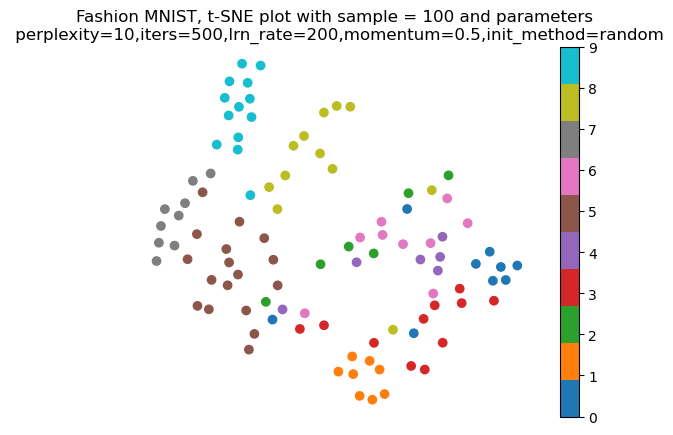

In [14]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
X_sample = X[:n_sample:, ]
y_sample = y[:n_sample]
tsne = TSNE(perplexity=10, iterations=500, learning_rate=200, n_components=2)
solution, Y = tsne.fit(X_sample)
tsne.plot_embeddings(solution, y_sample)


# 2.2(1.5pts) Using the t-SNE method, please reduce the 784 dimensions to 2 dimensions. Please try at least 5 different hyperparameters conditions.

- For each hyperparameter condition, please calculate its corresponding D and J.
- Please calculate the sum of the distance D among the 10 centroids. 
- Each centroid corresponds to each label. Since there are 10 centroids, you should calculate distance for 45 pairs. 
- Also, please calculate the objective function J.
- Your goal is to maximize the distance D among the centroids and to minimize the objective function J by optimizing the hyperparameters.

$$

D = \sum_{i,j} \|y_i - y_j\|^2

\\

J = \sum_{i=1}^{k} \sum_{j=1}^{n} \|x_i - c_j\|^2

$$

In [15]:
def compute_centroids(embeddings, y):
    centroids = []
    for label in sorted(np.unique(y)):
        indices = np.where(y == label)[0]
        centroid = np.mean(embeddings[indices], axis=0)
        centroids.append(centroid)
    return np.array(centroids)


def compute_centroid_distance(centroids):
    D = 0.0
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            D += np.sum((centroids[i] - centroids[j]) ** 2)
    return D


def compute_objective_function(embedding, y, centroids):
    J = 0.0
    for idx, label in enumerate(sorted(np.unique(y))):
        indices = np.where(y == label)[0]
        J += np.sum(np.sum((embedding[indices] - centroids[idx]) ** 2, axis=1))
    return J

In [16]:
hyper_parameters = [
    {'perplexity': 10, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
    {'perplexity': 10, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
    {'perplexity': 30, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
    {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
    {'perplexity': 50, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
    {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
]

results = []
n_sample = 100
X_sample = X[:n_sample:, ]
y_sample = y[:n_sample]
for i, params in enumerate(hyper_parameters):
    print(f"Running Condition {i + 1}: {params}")
    
    tsne = TSNE(perplexity=params['perplexity'], iterations=params['iterations'], learning_rate=params['learning_rate'],)
    embeddings, Y = tsne.fit(X_sample)
    centroids = compute_centroids(embeddings, y_sample)
    D = compute_centroid_distance(centroids)
    J = compute_objective_function(embeddings, y_sample, centroids)
    results.append({'D': D, 'J': J, 'tsne': tsne, "centroids": centroids, "embeddings": embeddings, 
                    'params': tsne._params()})
    
    print(f"Condition {i + 1}: D = {D:.4f}, J = {J:.4f}")

Running Condition 1: {'perplexity': 10, 'learning_rate': 200, 'iterations': 500, 'momentum': 0.5, 'initialization_method': 'random'}
Starting the high dimension computation...


  0%|          | 0/100 [00:00<?, ?it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 2.078818658888834
Iteration 100: Value of Cost Function is 2.9136230908369303
Iteration 200: Value of Cost Function is 2.867360210468387
Iteration 300: Value of Cost Function is 0.7397038029249373
Iteration 400: Value of Cost Function is 0.4033837836277834
Completed Low Dimensional Embedding: Final Value of Cost Function is 0.4005258078170124
Condition 1: D = 13021916.7512, J = 3439468.6086
Running Condition 2: {'perplexity': 10, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'}
Starting the high dimension computation...


  0%|          | 0/100 [00:00<?, ?it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 2.0788186600249716
Iteration 100: Value of Cost Function is 3.2446576174915496
Iteration 200: Value of Cost Function is 3.533965553669543
Iteration 300: Value of Cost Function is 2.6256029308151887
Iteration 400: Value of Cost Function is 1.893158551969631
Iteration 500: Value of Cost Function is 0.4452970791729478
Iteration 600: Value of Cost Function is 0.4249408301338899
Iteration 700: Value of Cost Function is 0.4257394480380019
Iteration 800: Value of Cost Function is 0.4263639802458874
Iteration 900: Value of Cost Function is 0.4268192660040134
Completed Low Dimensional Embedding: Final Value of Cost Function is 0.42714146991227975
Condition 2: D = 428308600.1684, J = 108080067.4520
Running Condition 3: {'perplexity': 30, 'learning_rate': 200, 'iterations': 500, 'momentum': 0.5, 'ini

  0%|          | 0/100 [00:00<?, ?it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 1.0380028111897146
Iteration 100: Value of Cost Function is 2.3537461169255307
Iteration 200: Value of Cost Function is 2.398661176416748
Iteration 300: Value of Cost Function is 0.21131670063383456
Iteration 400: Value of Cost Function is 0.20730610531802263
Completed Low Dimensional Embedding: Final Value of Cost Function is 0.20475694516466827
Condition 3: D = 2809.5962, J = 810.2053
Running Condition 4: {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'}
Starting the high dimension computation...


  0%|          | 0/100 [00:00<?, ?it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 1.0380028105967898
Iteration 100: Value of Cost Function is 2.653923069505093
Iteration 200: Value of Cost Function is 2.7360295853692445
Iteration 300: Value of Cost Function is 0.9976874207892592
Iteration 400: Value of Cost Function is 1.000803020792437
Iteration 500: Value of Cost Function is 0.9855661384121974
Iteration 600: Value of Cost Function is 1.0558855177382918
Iteration 700: Value of Cost Function is 1.0187569254577362
Iteration 800: Value of Cost Function is 0.9414392226270347
Iteration 900: Value of Cost Function is 0.9906131179746707
Completed Low Dimensional Embedding: Final Value of Cost Function is 0.9245732329968372
Condition 4: D = 10707.8382, J = 6080.2475
Running Condition 5: {'perplexity': 50, 'learning_rate': 200, 'iterations': 500, 'momentum': 0.5, 'initializatio

  0%|          | 0/100 [00:00<?, ?it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 0.5695235475210236
Iteration 100: Value of Cost Function is 1.8973315137537496
Iteration 200: Value of Cost Function is 1.7726440156668668
Iteration 300: Value of Cost Function is 0.09600743549311397
Iteration 400: Value of Cost Function is 0.09363825165210213
Completed Low Dimensional Embedding: Final Value of Cost Function is 0.09363835704284065
Condition 5: D = 471.5139, J = 165.3598
Running Condition 6: {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'}
Starting the high dimension computation...


  0%|          | 0/100 [00:00<?, ?it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 1.0380028105570038
Iteration 100: Value of Cost Function is 2.7630007691904614
Iteration 200: Value of Cost Function is 2.6932203007021656
Iteration 300: Value of Cost Function is 1.3949174453076587
Iteration 400: Value of Cost Function is 0.9749085206270822
Iteration 500: Value of Cost Function is 1.0758838319212805
Iteration 600: Value of Cost Function is 1.0819943342414422
Iteration 700: Value of Cost Function is 1.000395664547817
Iteration 800: Value of Cost Function is 1.041379967115597
Iteration 900: Value of Cost Function is 0.875428260883806
Completed Low Dimensional Embedding: Final Value of Cost Function is 1.089604979076022
Condition 6: D = 11020.6596, J = 6642.6119


In [17]:
# import concurrent.futures
# 
# # Your hyperparameters
# hyper_parameters = [
#     {'perplexity': 10, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
#     {'perplexity': 10, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
#     {'perplexity': 30, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
#     {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
#     {'perplexity': 50, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
#     {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
# ]
# 
# # Define a function to process each set of parameters
# def run_tsne(params, X_sample, y_sample):
#     print(f"Running with parameters: {params}")
#     tsne = TSNE(perplexity=params['perplexity'], learning_rate=params['learning_rate'], iterations=params['iterations'], 
#                 momentum=params['momentum'], initialization_method=params['initialization_method'])
#     embeddings = tsne.fit_transform(X_sample)
#     centroids = compute_centroids(embeddings, y_sample)
#     D = compute_centroid_distance(centroids)
#     J = compute_objective_function(embeddings, y_sample, centroids)
#     result = {
#         'D': D, 'J': J, 'tsne': tsne, 'centroids': centroids, 'embeddings': embeddings,
#         'params': ",".join(f"{k}={v}" for k, v in params.items())
#     }
#     print(f"Completed: D = {D:.4f}, J = {J:.4f}")
#     return result
# 
# 
# 
# n_sample = 100
# X_sample = X[:n_sample:, ]
# y_sample = y[:n_sample]
# 
# # Using ProcessPoolExecutor for parallel execution
# results = []
# 
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     # Submit each set of hyperparameters for parallel processing
#     futures = [executor.submit(run_tsne, params, X_sample, y_sample) for params in hyper_parameters]
# 
#     # Collect the results as they complete
#     for future in concurrent.futures.as_completed(futures):
#         results.append(future.result())

In [18]:
results_df = pd.DataFrame.from_dict(results)
results_df[["params", "D", "J"]].head(10)


,params,D,J
0,"perplexity=10,iters=500,lrn_rate=200,momentum=...",1.302192e+07,3.439469e+06
1,"perplexity=10,iters=1000,lrn_rate=500,momentum...",4.283086e+08,1.080801e+08
2,"perplexity=30,iters=500,lrn_rate=200,momentum=...",2.809596e+03,8.102053e+02
3,"perplexity=30,iters=1000,lrn_rate=500,momentum...",1.070784e+04,6.080248e+03
4,"perplexity=50,iters=500,lrn_rate=200,momentum=...",4.715139e+02,1.653598e+02
5,"perplexity=30,iters=1000,lrn_rate=500,momentum...",1.102066e+04,6.642612e+03


# 2.3(1.5pts)

- Please draw 2D plot for the 5 hyperparameter conditions.
- Please legend different colors for the 10 labels in the graph.

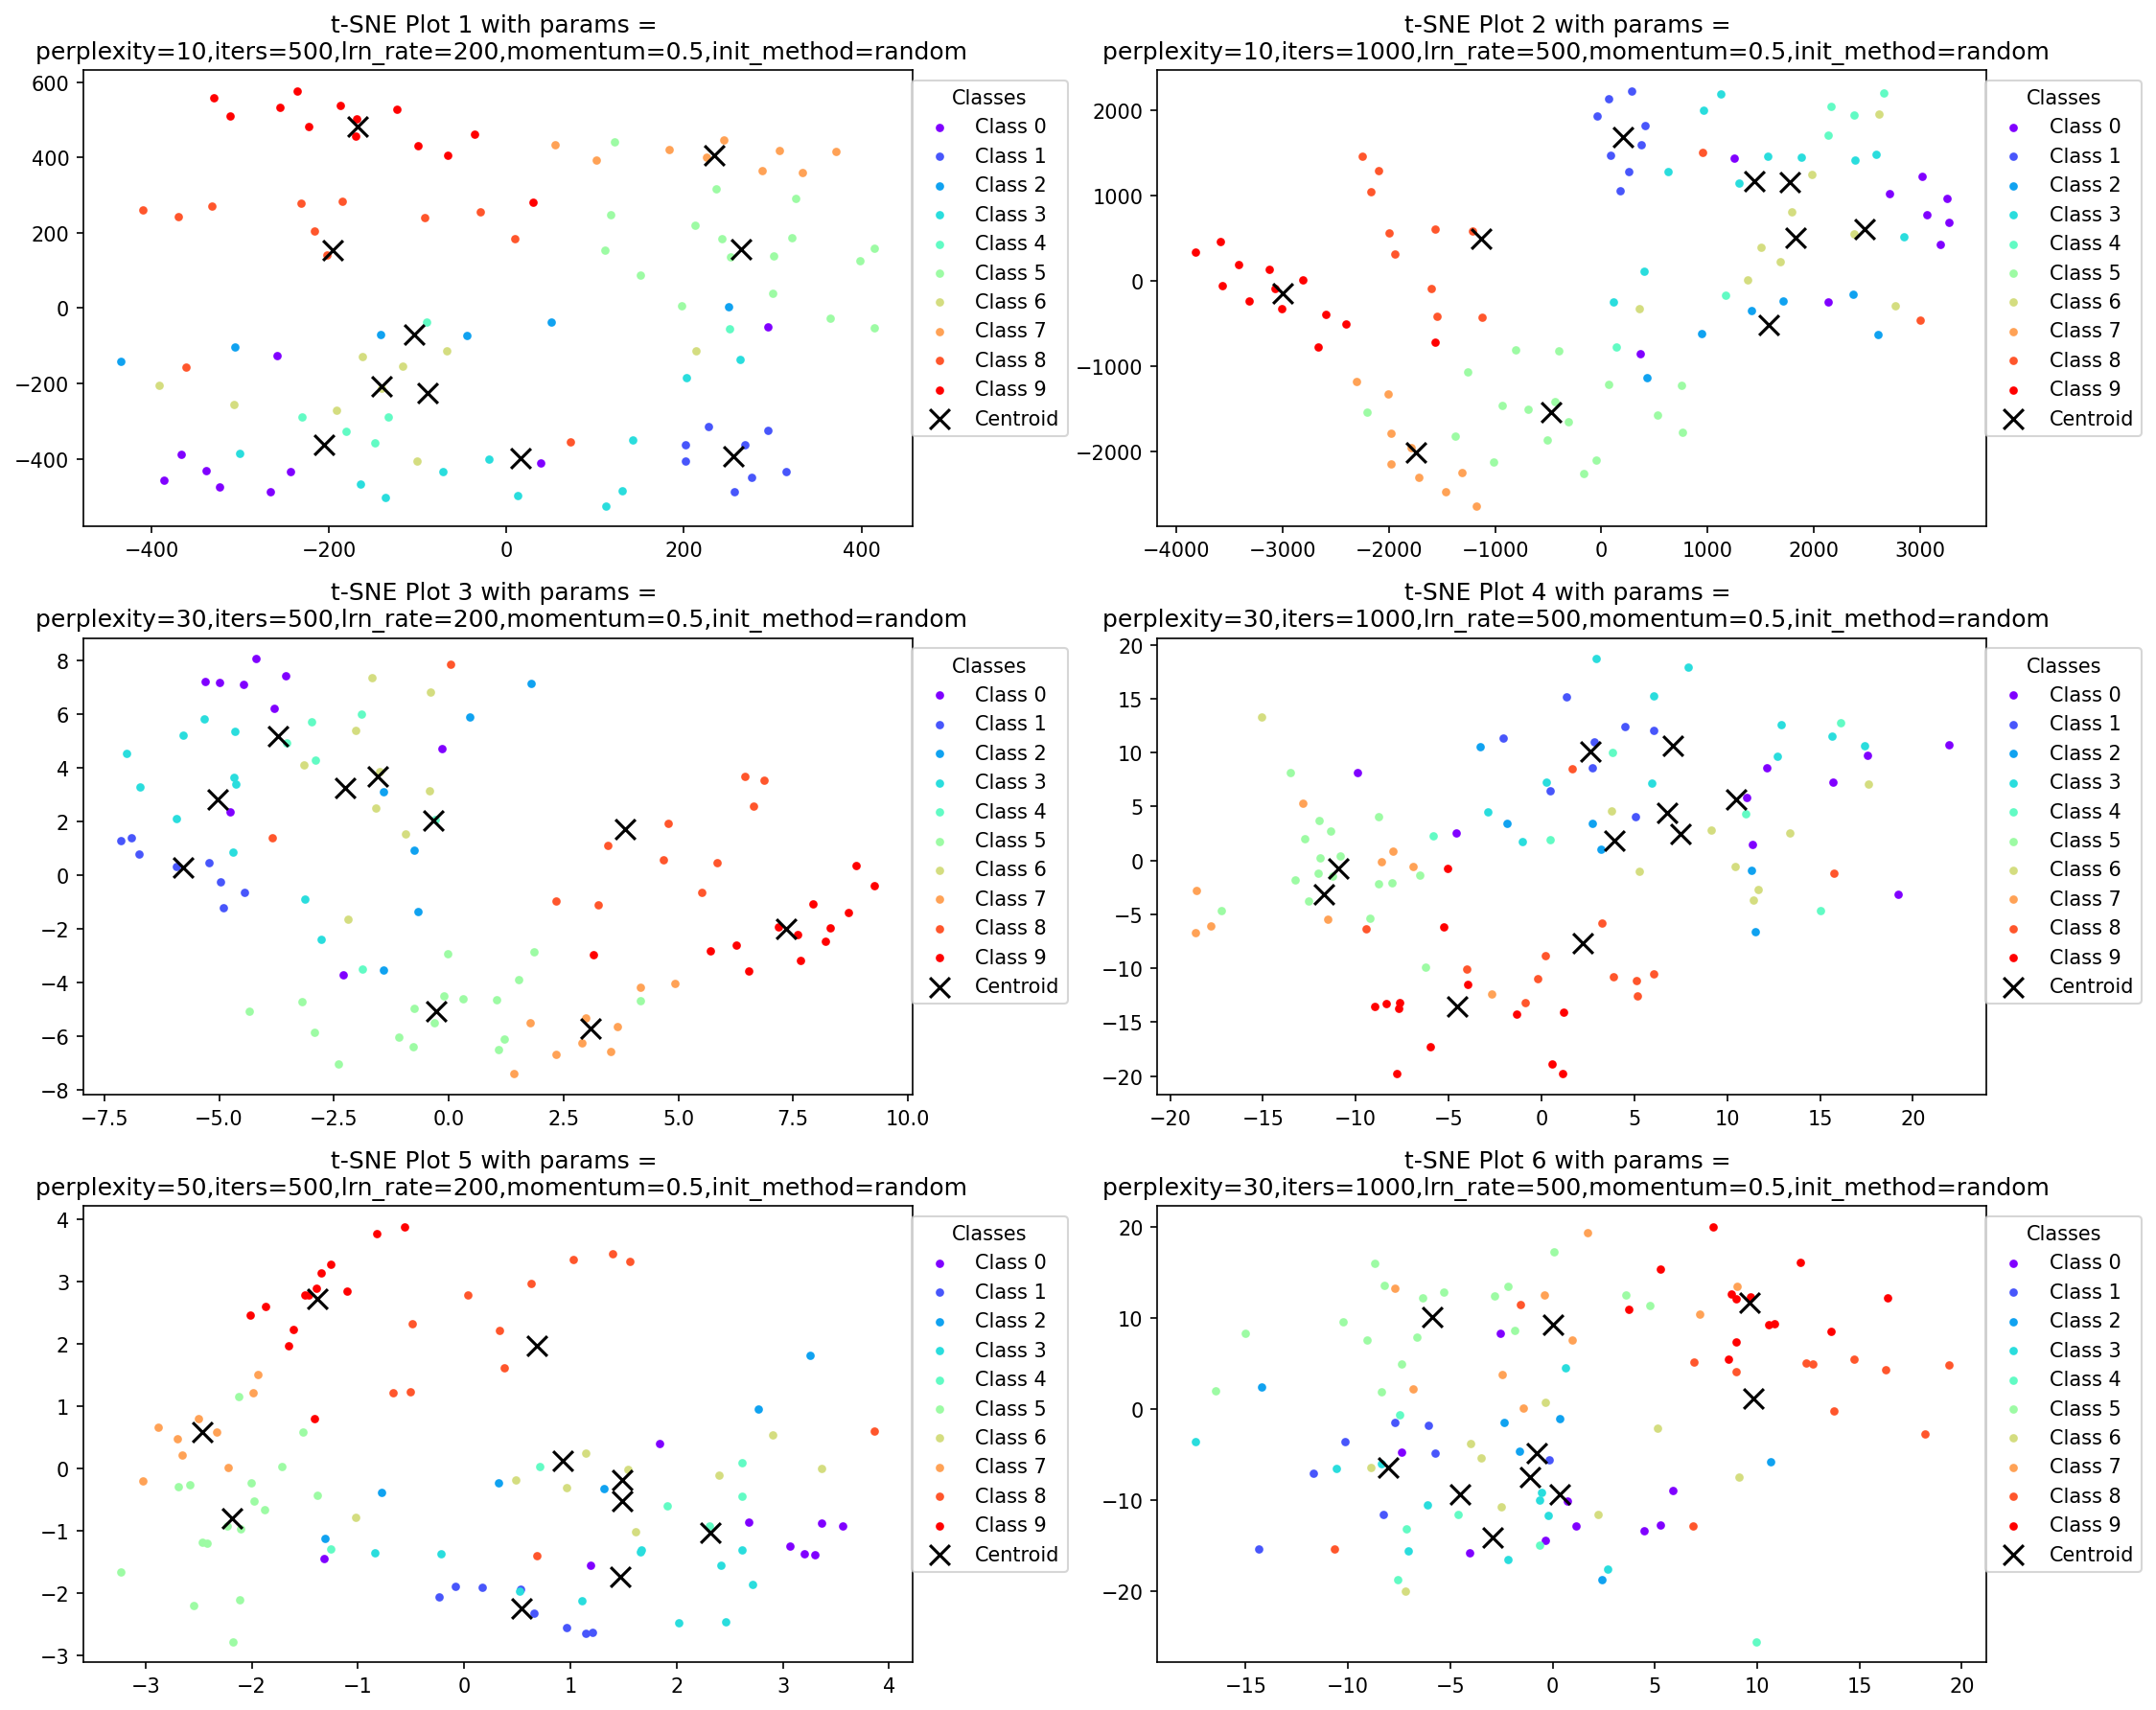

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12), dpi=150)
axes = axes.ravel()
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(y_sample))))  # Generate colors

# Iterate over each dictionary and each subplot
for i, data in enumerate(results):
    ax = axes[i]
    
    # Extract embeddings, labels, and centroids from the data
    embeddings = data['embeddings']
    labels = y_sample
    centroids = data['centroids']
    
    # Plot the t-SNE points for each class with a unique color
    for j, class_label in enumerate(sorted(np.unique(labels))):
        class_points = embeddings[labels == class_label]
        ax.scatter(class_points[:, 0], class_points[:, 1], color=colors[j], label=f"Class {class_label}", s=10)
    
    # Plot the centroids for each class
    ax.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroid')
    
    # Set a title for the plot
    ax.set_title(f"t-SNE Plot {i+1} with params = \n {data['params']}")
    
    # Add legend for the class colors
    ax.legend(loc='upper right', title="Classes",  bbox_to_anchor=(1.2, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
